# Simulation of a water box using the $q$-potential

This will simulate a box of SPC/E water using a custom nonbonded force based on a tabulated $q$-potential. It can also perform a simulation using Ewald summation.

Install prerequisites using `conda`:
```bash
    $ conda config --add channels omnia
    $ conda install -c omnia openmm mdtraj packmol
```

In [1]:
%matplotlib inline
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from sys import stdout
import matplotlib.pyplot as plt
from io import StringIO
import numpy as np, os

In [2]:
# simulation parameters: more to be added

nsteps  = 50000   # number of MD steps
boxlen  = 18.6206 # size of the cubic box in Å
nwater  = 216     # number of water molecules
NPT     = False   # NPT ensemble using pressure coupling?

# write input file for packmol
PACKMOL_INPUT = """ 
tolerance %f
filetype pdb
output %s

# hoh will be put in a box
# defined by the minimum coordinates x, y and z = 0. 0. 0. and maximum
# coordinates box_size box_size box_size That is, they will be put in a cube of side
# box_size (the keyword "inside cube 0. 0. 0. box_size") could be used as well.

structure %s
  number %d
  inside box 0. 0. 0. %f %f %f 
  add_box_sides 0.0
end structure
""" % (2.,'box.pdb','hoh.pdb', nwater, boxlen, boxlen, boxlen)

!echo '$PACKMOL_INPUT' > packmol_input.txt

In [3]:
%%writefile hoh.pdb
CRYST1   30.000   30.000   30.000  90.00  90.00  90.00 P 1           1
ATOM      1  O   HOH A   1      27.552  11.051   7.172  1.00  0.00          O
ATOM      2  H1  HOH A   1      27.900  10.721   8.050  1.00  0.00          H
ATOM      3  H2  HOH A   1      26.606  11.355   7.281  1.00  0.00          H 
END

Overwriting hoh.pdb


In [4]:
# use packmol to create a system of randomly placed molecules
!packmol < packmol_input.txt > /dev/null

In [5]:
def findForce(system, forcetype, add=True):
    """ Finds a specific force in the system force list - added if not found."""
    for force in system.getForces():
        if isinstance(force, forcetype):
            return force
    if add==True:
        system.addForce(forcetype())
        return findForce(system, forcetype)
    return None

def make_qpotential_system(topology, cutoff=0.9*nanometers):
    ff = ForceField('spce-qpot.xml')
    system = ff.createSystem(
        topology, nonbondedMethod=CutoffPeriodic,
        nonbondedCutoff=cutoff, constraints=HBonds, rigidWater=True)

    # tabulated q-potential to be implemented
    x = np.linspace( 0.001,1, 1000 )
    array = 1/x-1
    fwolf = Continuous1DFunction(array, 0*nanometers, 1*nanometers)

    nonbonded = findForce(system, CustomNonbondedForce)
    nonbonded.addTabulatedFunction('wolf', fwolf) # 'wolf(r)' can now be used in energy function
    nonbonded.addGlobalParameter('Rc', cutoff)    # 'Rc' can now be used in energy function
    nonbonded.setEnergyFunction(
        'charge1*charge2*wolf(r)' \
        ' + 4*epsilon*((sigma/r)^12-(sigma/r)^6) ; sigma=0.5*(sigma1+sigma2); epsilon=sqrt(epsilon1*epsilon2)' )
    print('Pair potential:\n  u12(r) =', nonbonded.getEnergyFunction())
    return system

def make_ewald_system(topology, cutoff=0.9*nanometers):
    ff = ForceField('spce.xml')
    return ff.createSystem(
        topology, nonbondedMethod=Ewald,
        nonbondedCutoff=cutoff, constraints=HBonds, rigidWater=True)
    
print('Creating OpenMM System')

pdb = PDBFile('box.pdb')

#system = make_qpotential_system( pdb.topology )
system = make_ewald_system( pdb.topology )

integrator = LangevinIntegrator( 298.15*kelvin, 1.0/picoseconds, 2*femtoseconds )
integrator.setConstraintTolerance(0.00001)

if NPT:
    barostat = MonteCarloBarostat(1.0*bar, 298.15*kelvin, 25) 
    system.addForce(barostat)

platform = Platform.getPlatformByName('CPU')

# Create the Simulation object
sim = Simulation(pdb.topology, system, integrator, platform)
sim.context.setPositions(pdb.positions) # set particle positions

Creating OpenMM System


In [6]:
minimize=True
production=True
restart=True
restartfile='out.chk'
trjfile='out.dcd'

if minimize:
    print('Minimizing energy...')
    sim.reporters.clear()
    sim.minimizeEnergy( tolerance=50*kilojoule/mole, maxIterations=1000 )
    sim.context.setVelocitiesToTemperature( 298.15*kelvin ) # initial random velocities

if production:
    print('Running Production...')
    sim.reporters.clear()
    sim.reporters.append( DCDReporter( trjfile, 100) )
    
    sim.reporters.append( StateDataReporter('energy.dat', 500, step=True, potentialEnergy=True,
                                            temperature=True, density=True) )
    
    sim.reporters.append( StateDataReporter(stdout, 500, step=True, potentialEnergy=True,
                                            temperature=True, density=True, separator='\t',
                                            progress=True,
                                            totalSteps = nsteps) )

    if restart:
        if os.path.isfile( restartfile ):
            with open( restartfile, 'rb') as f:
                print('Loading restart file.')
                sim.context.loadCheckpoint( f.read() )

    sim.step( nsteps )

    with open( restartfile, 'wb') as f:
        print('Saving restart file.')
        f.write( sim.context.createCheckpoint() )

# save final configuration to PDB file
positions = sim.context.getState(getPositions=True).getPositions()
PDBFile.writeFile(sim.topology, positions, open('out.pdb', 'w'))
print('Done!')

Minimizing energy...
Running Production...
Loading restart file.
#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Density (g/mL)"
1.0%	500	-10104.381621942353	289.8826694700373	1.0009348752917118
2.0%	1000	-10121.620423209191	301.5122123602971	1.0009348752917118
3.0%	1500	-10144.818340562786	286.4730218415645	1.0009348752917118
4.0%	2000	-10236.497995536556	294.35261571167274	1.0009348752917118
5.0%	2500	-10207.998121233395	296.9523022157397	1.0009348752917118
6.0%	3000	-10162.126414058635	293.43951004612825	1.0009348752917118
7.0%	3500	-10005.562330404726	295.1703766015995	1.0009348752917118
8.0%	4000	-10155.317665216287	294.9846496466838	1.0009348752917118
9.0%	4500	-10258.999401456007	298.78592177062717	1.0009348752917118
10.0%	5000	-10133.981670274312	303.8258779760854	1.0009348752917118
11.0%	5500	-10238.180792649327	299.1794412781149	1.0009348752917118
12.0%	6000	-10156.932402900806	308.0220160426882	1.0009348752917118
13.0%	6500	-10053.013762353374	295.4467

In [10]:
### Oxygen-oxygen radial distribution function

Number of atoms = 648
Number of residues = 216
Number of frames = 499


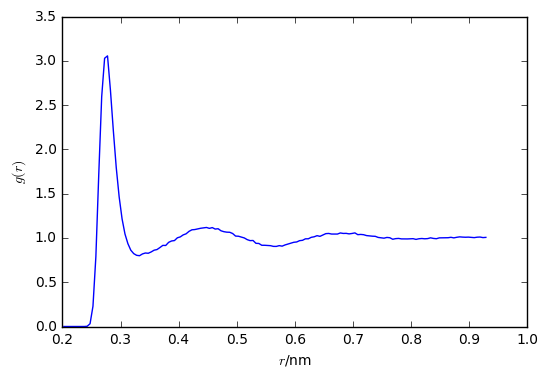

In [7]:
import mdtraj as md
traj = md.load('out.dcd', top='out.pdb')
print('Number of atoms    = %s' % traj.n_atoms)
print('Number of residues = %s' % traj.n_residues)
print('Number of frames   = %s' % traj.n_frames)

sel = traj.top.select('name O')
OOpairs = traj.top.select_pairs('name O', 'name O')
rdf = md.compute_rdf( traj, pairs=OOpairs, bin_width=0.005, r_range=[0.2, boxlen/2/10] )
plt.plot( rdf[0], rdf[1])
plt.xlabel(r'$r$/nm')
plt.ylabel(r'$g(r)$')

### Average potential energy

Average potential energy =  -10112.5571297  kJ/mol


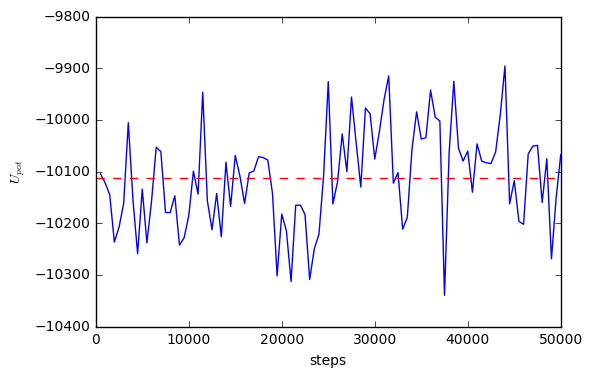

In [16]:
step, Upot, temp, density = np.loadtxt('energy.dat', skiprows=1, delimiter=',', unpack=True)
plt.plot(step, Upot)
plt.xlabel(r'steps')
plt.ylabel(r'$U_{pot}$')
plt.plot([0,step.max()], [Upot.mean(), Upot.mean()], 'r--')
print('Average potential energy = ', Upot.mean(), ' kJ/mol')

### Static dielectric constant

The exact formula is not given in the `mdtraj` documentation, but can be found in the source code on github,

https://github.com/mdtraj/mdtraj/blob/master/mdtraj/geometry/thermodynamic_properties.py#L90

In [9]:
# first let's extract all charges
chargelist = []
for force in system.getForces():
    if 'getParticleParameters' in dir(force):
        for i in range(force.getNumParticles()):
            charge, sigma, epsilon = force.getParticleParameters(i)
            chargelist.append( charge / elementary_charge )
            
print('Static dielectric constant = ', md.static_dielectric(traj, chargelist, temperature=298.15))

Static dielectric constant =  45.91870507211941


In [34]:
# dielectric constant from only half the frames
md.static_dielectric(traj[::2], chargelist, temperature=298.15)

45.32054012862557